# HR AI Assistant

## In this project, i create a recruitment workflow using LangGraph, LangChain, and various APIs to automate and streamline the job posting and candidate evaluation process. The workflow consists of the following key steps:

* Requirements Gathering: The AI agent prompts the user for detailed job requirements, including the job title, company description, candidate responsibilities and qualifications, preferred location, and other relevant details.

* Job Description Generation: Once the job requirements are gathered, the agent generates a professional and compelling job description. The user can then review and approve the description, or provide feedback for the agent to refine it.

* LinkedIn Candidate Search and Outreach: If the user provides specific LinkedIn profiles of preferred candidates, the agent will directly message them about the opportunity. Alternatively, the agent can search LinkedIn for relevant candidates based on the job details and send outreach messages.

* CV Analysis: As candidates submit their CVs, the agent evaluates them against the job requirements, providing a score and recommendation (approve or reject) for each applicant. The agent then sends the appropriate response message to the candidate via LinkedIn.

* Interview Question Preparation: For approved candidates, the agent generates a set of interview questions covering technical skills, experience, and problem-solving. The user can review and approve the questions before the interviews are conducted.

## Installing required packages

In [ ]:
!pip install langchain langchain-anthropic langgraph python-dotenv pydantic langchain_community requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36


In [ ]:
# Core imports
import os
from typing import Dict, Any, List, Optional, Literal, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from datetime import datetime
import operator
import json
import uuid
import requests

# LangChain imports
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.tools import tool
from langchain_community.utilities import GoogleSerperAPIWrapper

# LangGraph imports
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt

# Display imports
from IPython.display import Image, display

In [ ]:
# API Keys
os.environ["ANTHROPIC_API_KEY"] = "anthropic_api_key"
os.environ["SERPER_API_KEY"] = "Serper_api_key"
os.environ["LINKEDIN_COOKIE"] = "linkedin_cookie"

llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=0)

# Initialize search utility
search = GoogleSerperAPIWrapper()

 # Defining base models

In [ ]:
# Job requirements model
class JobRequirements(BaseModel):
    # Details about the job requirements
    title: str
    company_description: str
    job_requirements: List[str]
    candidate_responsibilities: List[str]
    candidate_qualifications: List[str]
    company_benefits: List[str]
    interview_date: datetime
    preferred_country: str
    years_experience: int
    linkedin_profiles: Optional[List[str]] = None
    skills_required: List[str]
    salary_range: str



# Candidate profile model
class CandidateProfile(BaseModel):
    # Details about the candidate
    name: str
    linkedin_url: str
    title: str
    location: str
    cv_content: Optional[str] = None
    cv_score: Optional[float] = None
    status: str = "new"  # 'new', 'contacted', 'cv_received', 'approved', 'rejected'
    feedback: Optional[str] = None
    source: str = "direct"  # 'direct' or 'search'
    skill_matches: Optional[List[str]] = None
    skill_gaps: Optional[List[str]] = None
    message_sent: Optional[str] = None

# Main State Model
class RecruitmentState(BaseModel):
    # Overall state of the recruitment process
    phase: str
    messages: Annotated[List[BaseMessage], add_messages]
    job_requirements: Optional[JobRequirements]
    job_description: Optional[str]
    job_description_approved: bool
    candidates: Annotated[List[CandidateProfile], operator.add]
    linkedin_process_complete: bool
    cv_analysis_complete: bool
    interview_questions: Optional[List[str]]
    interview_questions_approved: bool

# Defining tool functions

In [ ]:
# Search for LinkedIn candidates using Google Serper API
@tool
def search_linkedin_candidates(
    job_title: str,
    location: str,
    skills: List[str],
    limit: int = 5
) -> List[Dict[str, str]]:
    """Search for candidates on LinkedIn using Google Search API"""
    search = GoogleSerperAPIWrapper()
    search_query = f"""site:linkedin.com/in/
        {job_title}
        {location}
        {' '.join(skills)}"""

    try:
        results = search.results(search_query)
        candidates = []
        for result in results.get('organic', [])[:limit]:
            if "linkedin.com/in/" in result.get("link", ""):
                candidates.append({
                    "linkedin_url": result["link"],
                    "title": result.get("title", ""),
                    "snippet": result.get("snippet", "")
                })
        return candidates
    except Exception as e:
        return [{"error": str(e)}]


# Get detailed LinkedIn profile information
@tool
def get_linkedin_profile(profile_url: str) -> Dict[str, Any]:
    """Get detailed profile information from LinkedIn URL"""
    headers = {
        'cookie': os.getenv("LINKEDIN_COOKIE"),
        'accept': 'application/json'
    }
    try:
        profile_id = profile_url.split('/in/')[-1].split('/')[0]
        api_url = f"https://www.linkedin.com/voyager/api/identity/profiles/{profile_id}/profileView"
        response = requests.get(api_url, headers=headers)
        data = response.json()

        return {
            "name": f"{data.get('firstName', '')} {data.get('lastName', '')}",
            "title": data.get('headline', ''),
            "location": data.get('locationName', ''),
            "skills": [skill.get('name', '') for skill in data.get('skills', [])]
        }
    except Exception as e:
        return {"error": str(e)}


# Send a message to a LinkedIn candidate about the job opportunity
@tool
def send_linkedin_message(profile_url: str, job_details: str) -> Dict[str, str]:
    """Send a LinkedIn message to a candidate about the job opportunity"""
    headers = {
        'cookie': os.getenv("LINKEDIN_COOKIE"),
        'accept': 'application/json'
    }
    try:
        profile_id = profile_url.split('/in/')[-1].split('/')[0]

        # Generate personalized message
        message_prompt = [
            SystemMessage(content="Generate a personalized LinkedIn outreach message for a job opportunity. Ask them to submit their CV directly through LinkedIn messages if interested."),
            HumanMessage(content=f"Job Details:\n{job_details}")
        ]
        message_content = llm.invoke(message_prompt).content

        # Send message via LinkedIn API
        message_endpoint = f"https://www.linkedin.com/voyager/api/messaging/conversations"
        payload = {
            "recipients": [profile_id],
            "message": message_content
        }
        response = requests.post(message_endpoint, headers=headers, json=payload)

        return {
            "status": "sent",
            "profile_id": profile_id,
            "message": message_content
        }
    except Exception as e:
        return {"error": str(e)}

# Defining workflow nodes

In [ ]:
# Requirements gathering node
def requirements_gathering(state: RecruitmentState) -> Dict[str, Any]:
    """Initialize or continue requirements gathering process"""
    if not state.messages:
        job_title = input("What is the job title? ")
        company_description = input("Provide a description of the company: ")
        job_requirements = input("List the job requirements (comma-separated): ").split(",")
        candidate_responsibilities = input("List the candidate responsibilities (comma-separated): ").split(",")
        candidate_qualifications = input("List the candidate qualifications (comma-separated): ").split(",")
        company_benefits = input("List the company benefits (comma-separated): ").split(",")
        interview_date = input("What is the interview date (YYYY-MM-DD)? ")
        preferred_country = input("What is the preferred country for the role? ")
        years_experience = int(input("What is the required years of experience? "))
        linkedin_profiles = input("Provide any LinkedIn profile URLs (comma-separated, optional): ").split(",")
        skills_required = input("List the required skills (comma-separated): ").split(",")
        salary_range = input("What is the salary range for the role? ")
        google_form_url = input("Provide the Google Form URL for CV submissions: ")

        job_requirements = JobRequirements(
            title=job_title,
            company_description=company_description,
            job_requirements=job_requirements,
            candidate_responsibilities=candidate_responsibilities,
            candidate_qualifications=candidate_qualifications,
            company_benefits=company_benefits,
            interview_date=datetime.strptime(interview_date, "%Y-%m-%d"),
            preferred_country=preferred_country,
            years_experience=years_experience,
            linkedin_profiles=[p.strip() for p in linkedin_profiles if p.strip()],
            skills_required=skills_required,
            salary_range=salary_range,
            google_form_url=google_form_url
        )

        return {
            "messages": [
                SystemMessage(content="You are an HR assistant gathering detailed job requirements."),
                HumanMessage(content="Let's begin gathering the job requirements. What is the job title?")
            ],
            "job_requirements": job_requirements,
            "phase": "requirements_gathering"
        }
    else:
        return state


# Job description generation node
def generate_job_desc(state: RecruitmentState) -> Dict[str, Any]:
    """Generate job description with human-in-the-loop review"""
    if not state.job_requirements:
        raise ValueError("Job requirements missing")

    messages = [
        SystemMessage(content="""Create a professional and compelling job description with:
        1. About the Company
        2. Role Overview
        3. Key Responsibilities
        4. Required Qualifications
        5. What We Offer (Benefits)
        6. Location and Work Mode"""),
        HumanMessage(content=str(state.job_requirements.model_dump()))
    ]

    response = llm.invoke(messages)

    # Raise NodeInterrupt for human review
    raise NodeInterrupt(
        f"Please review the generated job description:\n\n{response.content}"
    )

# LinkedIn process node

In [ ]:
def linkedin_process(state: RecruitmentState) -> Dict[str, Any]:
     # Implementation to handle the LinkedIn candidate search and outreach process
    """Handle LinkedIn candidate search/outreach process"""
    candidates = []
    tool_node = ToolNode([search_linkedin_candidates, get_linkedin_profile, send_linkedin_message])

    job_details = f"""
    Role: {state.job_requirements.title}
    Company: {state.job_requirements.company_description}
    Location: {state.job_requirements.preferred_country}
    Description: {state.job_description}
    """

    if state.job_requirements.linkedin_profiles:
        # Process provided profiles
        for profile_url in state.job_requirements.linkedin_profiles:
            profile = tool_node.invoke({
                "name": "get_linkedin_profile",
                "args": {"profile_url": profile_url}
            })

            if "error" not in profile:
                message_result = tool_node.invoke({
                    "name": "send_linkedin_message",
                    "args": {
                        "profile_url": profile_url,
                        "job_details": job_details
                    }
                })

                if "error" not in message_result:
                    candidates.append(
                        CandidateProfile(
                            **profile,
                            linkedin_url=profile_url,
                            status="contacted",
                            message_sent=message_result["message"]
                        )
                    )
    else:
        # Search for candidates using Serper API
        search_results = tool_node.invoke({
            "name": "search_linkedin_candidates",
            "args": {
                "job_title": state.job_requirements.title,
                "location": state.job_requirements.preferred_country,
                "skills": state.job_requirements.skills_required
            }
        })

        for result in search_results:
            if "error" not in result:
                profile = tool_node.invoke({
                    "name": "get_linkedin_profile",
                    "args": {"profile_url": result["linkedin_url"]}
                })

                if "error" not in profile:
                    message_result = tool_node.invoke({
                        "name": "send_linkedin_message",
                        "args": {
                            "profile_url": result["linkedin_url"],
                            "job_details": job_details
                        }
                    })

                    if "error" not in message_result:
                        candidates.append(
                            CandidateProfile(
                                **profile,
                                linkedin_url=result["linkedin_url"],
                                status="contacted",
                                source="search",
                                message_sent=message_result["message"]
                            )
                        )

    return {
        "candidates": candidates,
        "linkedin_process_complete": True,
        "phase": "analyze_cv"
    }

# CV analysis node

In [ ]:
def analyze_cv(state: RecruitmentState) -> Dict[str, Any]:
    # Implementation to analyze candidate CVs and send appropriate responses
    """Analyze CV and send appropriate response"""
    messages = [
        SystemMessage(content="""Analyze the CV against job requirements. Score from 0-10 on:
        1. Skills Match
        2. Experience Level
        3. Overall Fit

        Provide detailed feedback and clear recommendation."""),
        HumanMessage(content=f"""
        Job Requirements:
        {state.job_requirements.model_dump_json()}

        CV Content:
        {state.candidates[-1].cv_content}
        """)
    ]

    analysis = llm.invoke(messages)
    score = float(re.search(r"Overall Score:\s*(\d+\.?\d*)", analysis.content).group(1))

    tool_node = ToolNode([send_linkedin_message])

    if score >= 7.0:
        status = "approved"
        message = f"Congratulations! You've been selected for an interview on {state.job_requirements.interview_date}"
    else:
        status = "rejected"
        message = "Thank you for your application. Unfortunately..."

    # Send response via LinkedIn
    tool_node.invoke({
        "name": "send_linkedin_message",
        "args": {
            "profile_url": state.candidates[-1].linkedin_url,
            "message": message
        }
    })

    return {
        "cv_score": score,
        "status": status,
        "feedback": analysis.content,
        "phase": "prepare_interview" if status == "approved" else "complete"
    }


# Interview preparation node
def prepare_interview(state: RecruitmentState) -> Dict[str, Any]:
    """Generate interview questions with human approval"""
    messages = [
        SystemMessage(content="""Generate 10 interview questions covering:
        - Technical Skills (4)
        - Experience (3)
        - Problem Solving (3)"""),
        HumanMessage(content=f"""
        Position: {state.job_requirements.title}
        Required Skills: {', '.join(state.job_requirements.skills_required)}
        """)
    ]

    response = llm.invoke(messages)

    # Raise NodeInterrupt for human review
    raise NodeInterrupt(
        f"Please review the interview questions:\n\n{response.content}"
    )

# Creating the recruitment workflow

In [ ]:
def create_recruitment_workflow():
    """Create the recruitment workflow graph"""
    workflow = StateGraph(RecruitmentState)
    memory = MemorySaver()

    # Add nodes
    workflow.add_node("requirements_gathering", requirements_gathering)
    workflow.add_node("generate_job_desc", generate_job_desc)
    workflow.add_node("linkedin_process", linkedin_process)
    workflow.add_node("analyze_cv", analyze_cv)
    workflow.add_node("prepare_interview", prepare_interview)

    # Add edges with human-in-the-loop cycles
    workflow.add_edge(START, "requirements_gathering")
    workflow.add_edge("requirements_gathering", "generate_job_desc")

    def route_after_job_desc(state: RecruitmentState):
        return "linkedin_process" if state.job_description_approved else "generate_job_desc"

    def route_after_cv(state: RecruitmentState):
        return "prepare_interview" if state.status == "approved" else END

    workflow.add_conditional_edges(
        "generate_job_desc",
        route_after_job_desc,
        ["linkedin_process", "generate_job_desc"]
    )

    workflow.add_edge("linkedin_process", "analyze_cv")
    workflow.add_conditional_edges(
        "analyze_cv",
        route_after_cv,
        ["prepare_interview", END]
    )
    workflow.add_edge("prepare_interview", END)

    # Compile with breakpoints
    graph = workflow.compile(
        checkpointer=memory,
        interrupt_before=["generate_job_desc", "prepare_interview"]
    )

    # Generate and display the Mermaid visualization
    print("""graph TD
        Start --> requirements_gathering
        requirements_gathering --> generate_job_desc
        generate_job_desc -->|Approved| linkedin_process
        generate_job_desc -->|Not Approved| generate_job_desc
        linkedin_process --> analyze_cv
        analyze_cv -->|CV-Good| prepare_interview
        analyze_cv -->|CV-Bad| End
        prepare_interview -->|Approved| End
        prepare_interview -->|Not Approved| prepare_interview
    """)
    display(Image(graph.get_graph().draw_mermaid_png()))

    return graph





In [ ]:
def get_job_requirements():
    job_title = input("What is the job title? ")
    company_description = input("Provide a description of the company: ")
    job_requirements = input("List the job requirements (comma-separated): ").split(",")
    candidate_responsibilities = input("List the candidate responsibilities (comma-separated): ").split(",")
    candidate_qualifications = input("List the candidate qualifications (comma-separated): ").split(",")
    company_benefits = input("List the company benefits (comma-separated): ").split(",")
    interview_date = input("What is the interview date (YYYY-MM-DD)? ")
    preferred_country = input("What is the preferred country for the role? ")
    years_experience = int(input("What is the required years of experience? "))
    linkedin_profiles = input("Provide any LinkedIn profile URLs (comma-separated, optional): ").split(",")
    skills_required = input("List the required skills (comma-separated): ").split(",")
    salary_range = input("What is the salary range for the role? ")

    return JobRequirements(
        title=job_title,
        company_description=company_description,
        job_requirements=job_requirements,
        candidate_responsibilities = candidate_responsibilities,
        candidate_qualifications = candidate_qualifications,
        company_benefits = company_benefits,
        interview_date = interview_date,
        preferred_country = preferred_country,
        years_experience = years_experience,
        linkedin_profiles = linkedin_profiles,
        skills_required = skills_required,
        salary_range = salary_range,
    )

graph TD
        Start --> requirements_gathering
        requirements_gathering --> generate_job_desc
        generate_job_desc -->|Approved| linkedin_process
        generate_job_desc -->|Not Approved| generate_job_desc
        linkedin_process --> analyze_cv
        analyze_cv -->|CV-Good| prepare_interview
        analyze_cv -->|CV-Bad| End
        prepare_interview -->|Approved| End
        prepare_interview -->|Not Approved| prepare_interview
    


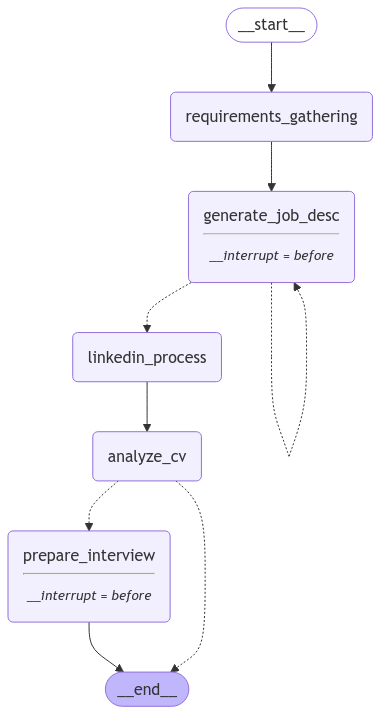


New State Update:
Phase: requirements_gathering


In [ ]:
# Create the recruitment workflow instance
recruitment_workflow = create_recruitment_workflow()

# Set the test configuration
config = {"configurable": {"thread_id": "test_1"}}

# Define the initial state of the recruitment process
initial_state = {
    "phase": "requirements_gathering",
    "messages": [],
    "job_requirements": None,
    "job_description": None,
    "job_description_approved": False,
    "candidates": [],
    "linkedin_process_complete": False,
    "cv_analysis_complete": False,
    "interview_questions": None,
    "interview_questions_approved": False
}

# Run the workflow and handle any interrupts
try:
    for event in recruitment_workflow.stream(initial_state, config, stream_mode="values"):
        print("\nNew State Update:")
        print(f"Phase: {event.get('phase')}")
        if event.get('messages'):
            print(f"Latest Message: {event['messages'][-1].content}")
except NodeInterrupt as e:
    print(f"\nHuman Review Required: {str(e)}")

    # Example of handling job description approval
    recruitment_workflow.update_state(
        config,
        {"job_description_approved": True}
    )

    # Continue the workflow execution
    for event in recruitment_workflow.stream(None, config, stream_mode="values"):
        print("\nNew State Update:")
        print(f"Phase: {event.get('phase')}")
        if event.get('messages'):
            print(f"Latest Message: {event['messages'][-1].content}")